In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [2]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

In [3]:
# !conda install conda-forge::segmentation-models-pytorch -y

## Dataset

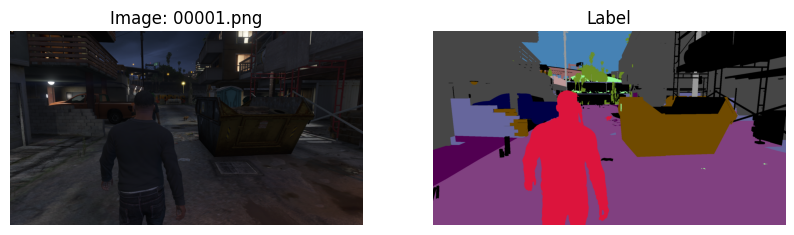

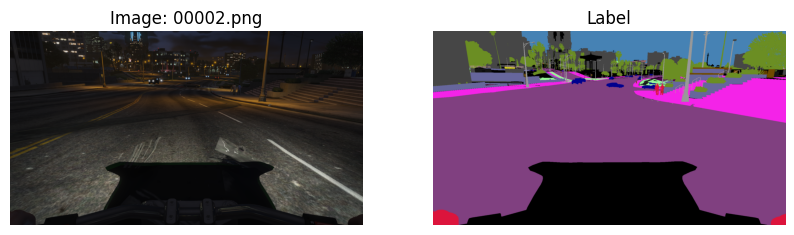

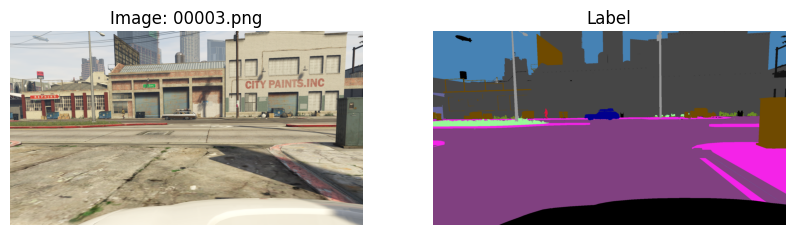

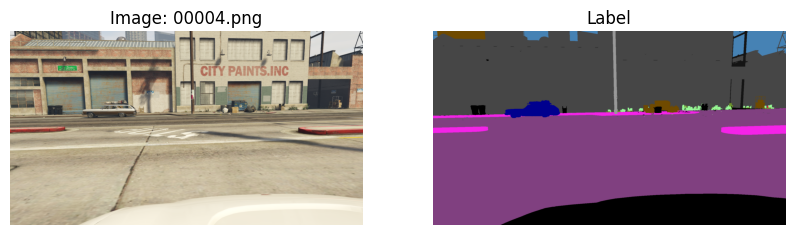

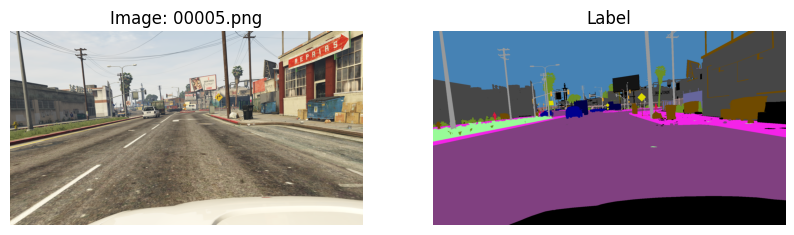

In [6]:
image_directory = "/gpfs/space/home/arammul/datasets/GTA-images/images"
label_directory = "/gpfs/space/home/arammul/datasets/GTA-images/labels"

image_files = sorted(os.listdir(image_directory))

for i, image_file in enumerate(image_files[:5]):
    if image_file.endswith(".png"):
        # Read the image
        image = Image.open(os.path.join(image_directory, image_file))
        
        # Get corresponding label filename
        label_file = os.path.join(label_directory, image_file)
        if os.path.exists(label_file):
            # Read the label
            label = Image.open(label_file)
            
            # Plot the images and labels side by side
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            axes[0].imshow(image)
            axes[0].set_title("Image: " + image_file)  # Add image title
            axes[0].axis('off')
            axes[1].imshow(label)
            axes[1].set_title("Label")
            axes[1].axis('off')
            plt.show()

In [7]:
X_train_val, X_test = train_test_split(image_files, test_size=0.1, random_state=42)
X_train, X_val = train_test_split(X_train_val, test_size=0.1111, random_state=42)

len(X_train), len(X_val), len(X_test)

(19972, 2497, 2497)

In [8]:
LABEL_TO_CLASS = {
  0: 'unlabeled'           ,
  1: 'ego vehicle'         ,
  2: 'rectification border',
  3: 'out of roi'          ,
  4: 'static'              ,
  5: 'dynamic'             ,
  6: 'ground'              ,
  7: 'road'                ,
  8: 'sidewalk'            ,
  9: 'parking'             ,
 10: 'rail track'          ,
 11: 'building'            ,
 12: 'wall'                ,
 13: 'fence'               ,
 14: 'guard rail'          ,
 15: 'bridge'              ,
 16: 'tunnel'              ,
 17: 'pole'                ,
 18: 'polegroup'           ,
 19: 'traffic light'       ,
 20: 'traffic sign'        ,
 21: 'vegetation'          ,
 22: 'terrain'             ,
 23: 'sky'                 ,
 24: 'person'              ,
 25: 'rider'               ,
 26: 'car'                 ,
 27: 'truck'               ,
 28: 'bus'                 ,
 29: 'caravan'             , 
 30: 'trailer'             , 
 31: 'train'               , 
 32: 'motorcycle'          , 
 33: 'bicycle'             , 
 34: 'license plate'       
}

In [9]:
import time

class GTA5Dataset(Dataset):
    def __init__(self, image_dir, label_dir, image_files, num_classes, preprocessing_fn=None, resize_dims=None, crop_dims=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_files = image_files
        self.num_classes = num_classes
        self.preprocessing_fn = preprocessing_fn
        self.resize = transforms.Resize(resize_dims) if resize_dims is not None else None
        self.crop_dims = crop_dims
        
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_file)
        label_path = os.path.join(self.label_dir, image_file)

        image = transforms.functional.to_tensor(Image.open(image_path)).type(torch.float32)
        label = torch.Tensor(np.array(Image.open(label_path))).type(torch.long).unsqueeze(0)
        
        # Apply transformations
        if self.resize:
            image = self.resize(image)
            label = self.resize(label)
        if self.crop_dims:
            params = transforms.RandomCrop.get_params(image, self.crop_dims)
            image = transforms.functional.crop(image, *params)
            label = transforms.functional.crop(label, *params)

        # Convert label from (W, H) to (C, W, H) - each class would have its own mask
        mask = F.one_hot(label, self.num_classes).squeeze(0).permute(2, 0, 1)

        # Applying standartization using the statistics of the pretrained model
        if self.preprocessing_fn:
            image = self.preprocessing_fn(image.permute(1,2,0)).permute(2,0,1)

        return (
            image.type(torch.float32), 
            mask.type(torch.float32)
        )

# Create custom dataset
dataset = GTA5Dataset(
    image_dir=image_directory, 
    label_dir=label_directory,
    image_files=X_train,
    num_classes=len(LABEL_TO_CLASS),
    resize_dims=(526, 957), 
    crop_dims=(512, 512)
)

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

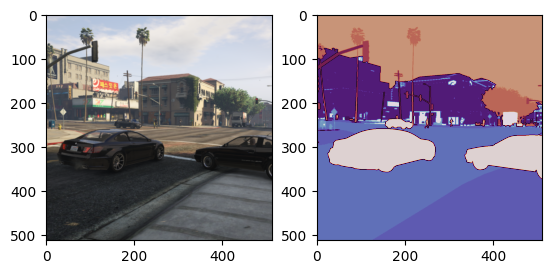

In [13]:
images, labels = next(iter(dataloader))

image, label = images[0].permute(1,2,0), labels[0].argmax(dim=0).type(torch.long)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(image)
ax2.imshow(label, cmap='twilight')
plt.show()

## Training

In [14]:
import segmentation_models_pytorch as smp

/gpfs/space/home/arammul/.conda/envs/nn-project/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
DEVICE = 'cuda'

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [16]:
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(LABEL_TO_CLASS),
)

In [17]:
train_dataset = GTA5Dataset(
    image_dir=image_directory, 
    label_dir=label_directory,
    image_files=X_train,
    num_classes=len(LABEL_TO_CLASS),
    preprocessing_fn=preprocessing_fn,
    resize_dims=(526, 957), 
    crop_dims=(512, 512)
)

valid_dataset = GTA5Dataset(
    image_dir=image_directory, 
    label_dir=label_directory,
    image_files=X_val,
    num_classes=len(LABEL_TO_CLASS),
    preprocessing_fn=preprocessing_fn,
    resize_dims=(526, 957), 
    crop_dims=(512, 512)
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=8)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=8)

In [26]:
from segmentation_models_pytorch import utils

In [27]:
loss = utils.losses.DiceLoss(activation='softmax2d')
metrics = [
    utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [28]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [29]:
max_score = 0
for i in range(0, 1):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')

    if i == 15:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train: 100%|█| 1249/1249 [33:30<00:00,  1.61s/it, dice_loss - 0.3568, iou_score 
valid: 100%|█| 157/157 [03:16<00:00,  1.25s/it, dice_loss - 0.2586, iou_score - 
Model saved!


## Testing

In [30]:
best_model = torch.load('./best_model.pth')

In [31]:
test_dataset = GTA5Dataset(
    image_dir=image_directory, 
    label_dir=label_directory,
    image_files=X_test,
    num_classes=len(LABEL_TO_CLASS),
    preprocessing_fn=preprocessing_fn,
    resize_dims=(526, 957), 
    crop_dims=(512, 512)
)

test_dataloader = DataLoader(test_dataset, batch_size=8, num_workers=4)

In [24]:
loss = utils.losses.DiceLoss(activation='softmax2d')
metrics = [
    utils.metrics.IoU(threshold=0.5),
]

test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|█| 313/313 [04:42<00:00,  1.11it/s, dice_loss - 0.2271, iou_score - 


In [25]:
logs

{'dice_loss': 0.22709417552612846, 'iou_score': 0.6255611709702891}

## Predictions visualization

In [32]:
test_dataset = GTA5Dataset(
    image_dir=image_directory, 
    label_dir=label_directory,
    image_files=X_test,
    num_classes=len(LABEL_TO_CLASS),
    preprocessing_fn=preprocessing_fn,
    resize_dims=(544, 960),
)

test_dataset_vis = GTA5Dataset(
    image_dir=image_directory, 
    label_dir=label_directory,
    image_files=X_test,
    num_classes=len(LABEL_TO_CLASS),
    resize_dims=(544, 960),
)

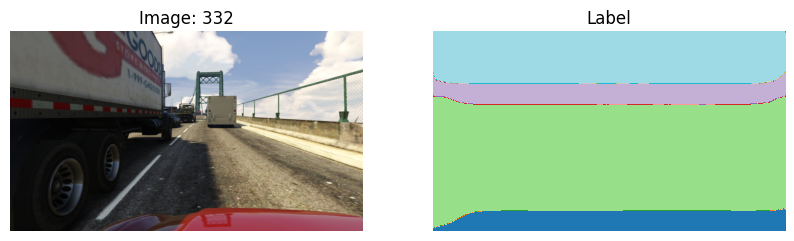

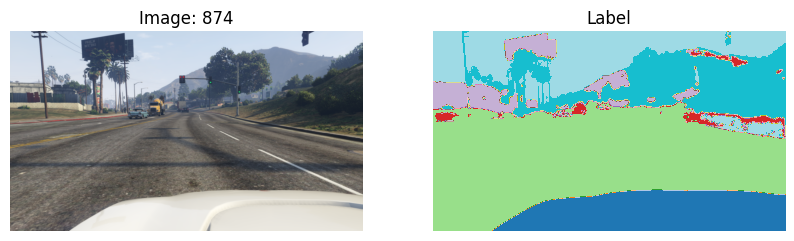

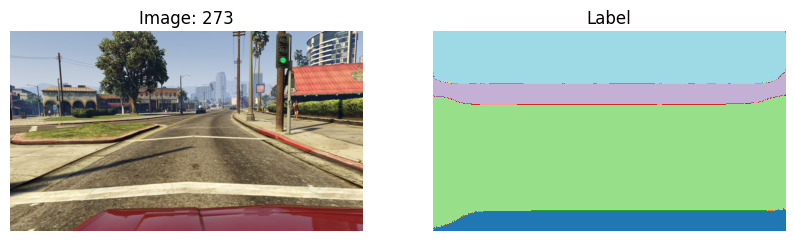

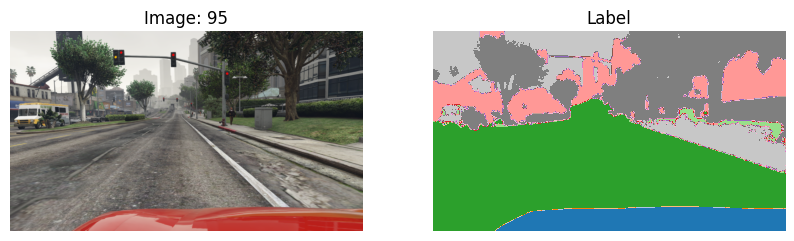

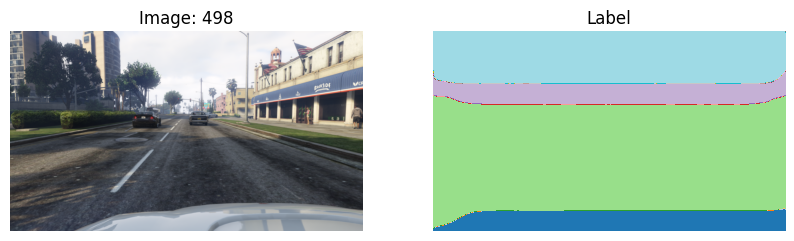

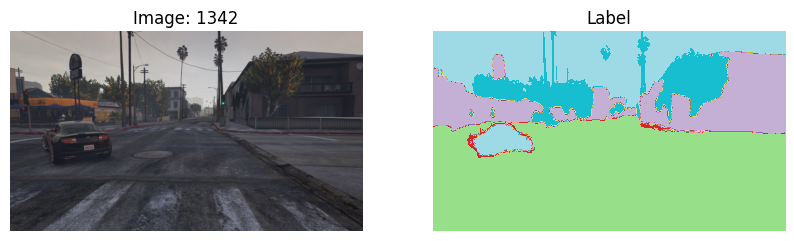

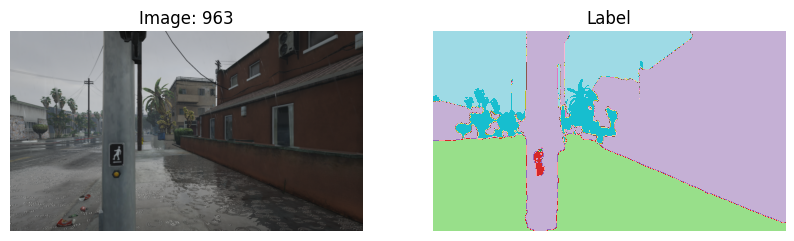

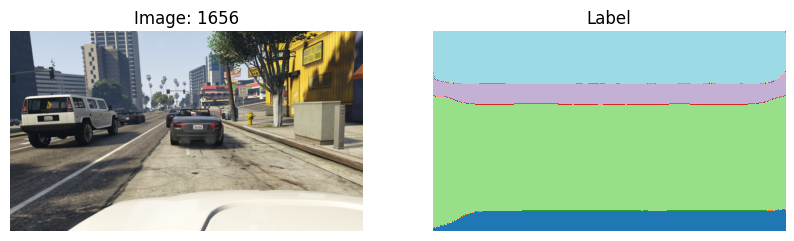

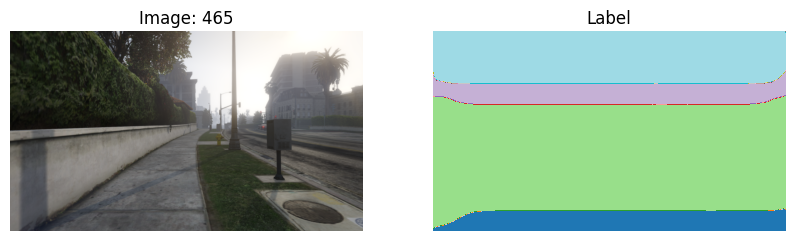

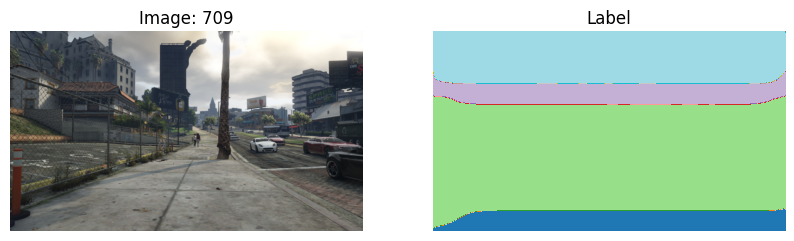

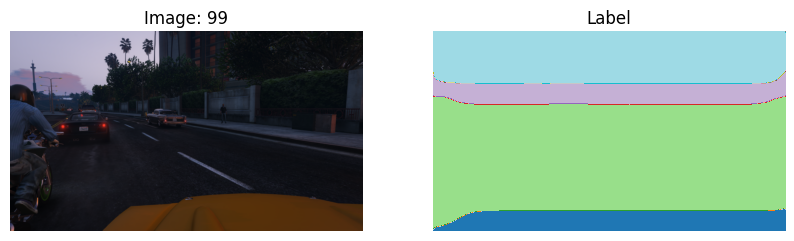

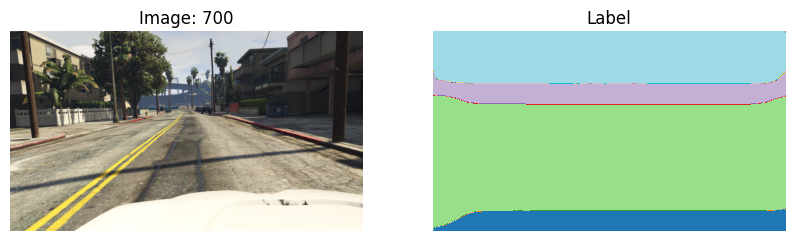

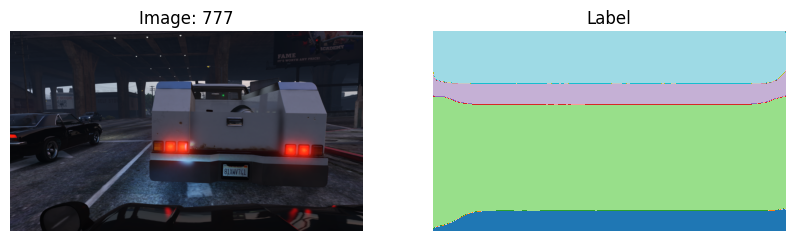

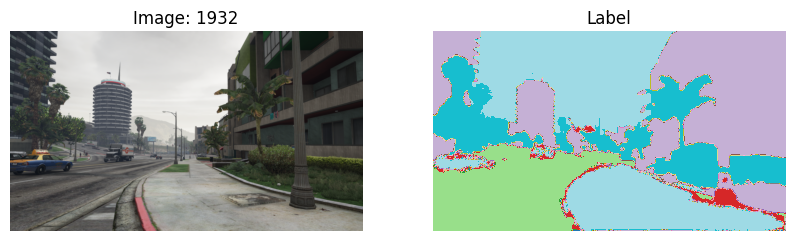

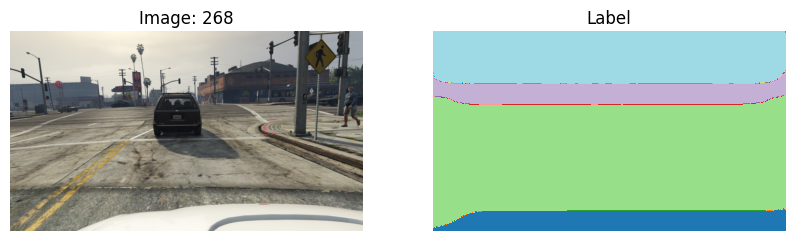

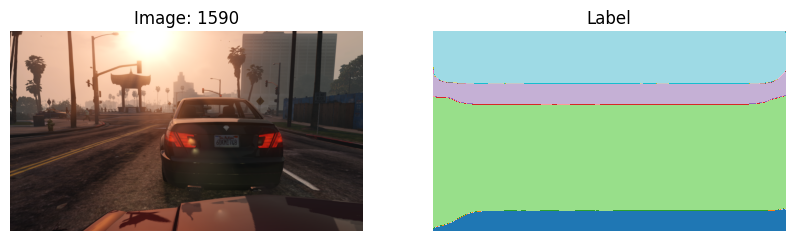

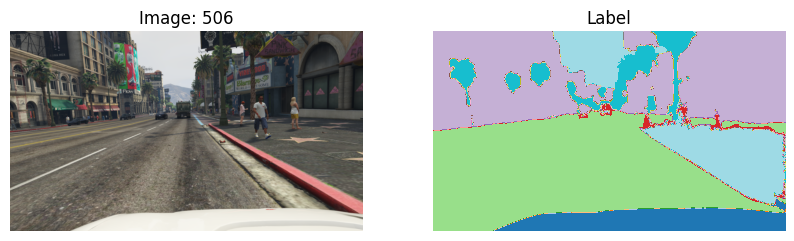

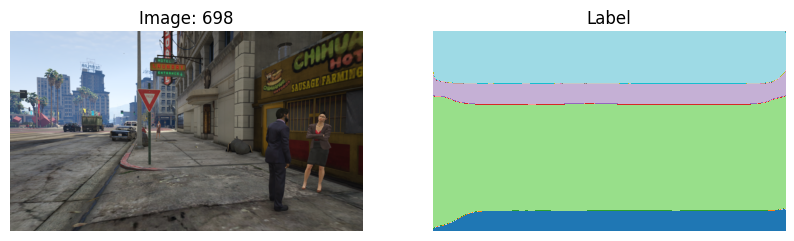

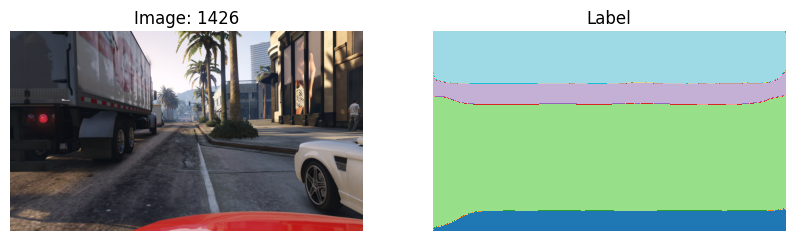

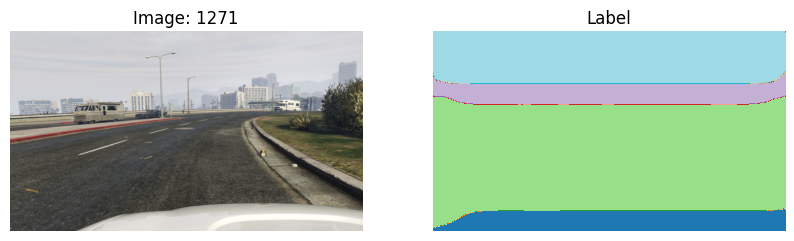

In [35]:
for i in range(20):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0]
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = image.to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor).cpu().squeeze(0).argmax(dim=0).type(torch.long).numpy().round()

    # remove
    # image_resized = Image.fromarray((image_vis.permute(1,2,0).cpu().numpy() * 255).round().astype(np.uint8)).resize((960, 544))
    # mask_resized = Image.fromarray(pr_mask.astype(np.uint8)).resize((960, 544))

    image_resized = Image.fromarray((image_vis.permute(1,2,0).cpu().numpy() * 255).round().astype(np.uint8))
    mask_resized = Image.fromarray(pr_mask.astype(np.uint8))

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image_resized)
    axes[0].set_title(f"Image: {n}")
    axes[0].axis('off')
    axes[1].imshow(mask_resized, cmap='tab20')
    axes[1].set_title("Label")
    axes[1].axis('off')
    plt.show()